jupyter nbconvert --execute --to html MicrosoftPrediction.ipynb --ExecutePreprocessor.timeout=-1

Above is the command needed to convert this to an html file. Set the timeout to -1 so the converter doesn't end the process early.

The goal of this analysis is to familiarize myself with time-series analysis and to run a sample simulation at the end to see how the model's accuracy would play out in the real world, assuming I buy as sell a single stock at a time, buying at the opening price for a day and selling at the closing price.

Note: I read a previous approach piror to my analysis at

https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

by Asutosh Nayak

I improved upon the ideas here to suit my own understanding of the problem and to simplify a lot of preprocessing required for the LSTM input. The architecture used for the LSTM was my own choice, as well as running a simulation.

In [1]:
from yahoo_fin import stock_info as si
import tensorflow as tf
from tensorflow import keras
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import numpy as np

Use the last 2 months of data to predict new day value so 'TIME_STEPS' = 60 days. Since the predictions are a day in advance 'DAYS_TO_PREDICT' = 1.

In [2]:
TIME_STEPS = 60
DAYS_TO_PREDICT = 1

# Use scalers to normalize values between 0 and 1
dataScaler = MinMaxScaler(feature_range=(0, 1))
outputScaler = MinMaxScaler(feature_range=(0, 1))

def buildTimeSeries(start_date, end_date):
    msft = si.get_data('MSFT', start_date=start_date, end_date=end_date)
    
    # Normalize values for training
    msftScaled = dataScaler.fit_transform(
        msft[['open', 'close', 'high', 'low', 'adjclose', 'volume']].values)
    outputScaled = outputScaler.fit_transform(msft[['close']].values)
    
    # Keep track of each day's input (data) and output (labels) values to train and test predictive model
    data = []
    labels = []
    
    for i in range(TIME_STEPS, len(msft)-DAYS_TO_PREDICT):
        
        # Get dataframe of info from 60 days prior
        oldPrices = msftScaled[i-TIME_STEPS:i, :]
        data.append(oldPrices)
        # Get closing price for day after the oldPrices
        desiredOutput = outputScaled[i: i + DAYS_TO_PREDICT]
        labels.append(desiredOutput)
        
    data = np.array(data)
    labels = np.array(labels)
    labels = np.squeeze(labels)
    
    return data, labels

In [3]:
# Train on 13 years worth of data and test on 2018-2019 prices
train_start='01/01/2005'
train_end='12/31/2017'
xTrain, yTrain = buildTimeSeries(train_start, train_end)

test_start='01/01/2018'
test_end='05/31/2019'
xTest, yTest = buildTimeSeries(test_start, test_end)

In [4]:
# Ensure the shapes are correct for NN input/output
print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(3211, 60, 6)
(3211,)
(293, 60, 6)
(293,)


LSTM models are particularly useful when doing time series analysis because of the RNN architecture which allows a kind of memory to be stored of previous outputs. Although the prediction is only one day in advance, this general architecture should be able to be used for forecasting multiple days in advance (albeit with less accuracy).

tensorboard --logdir=./logs

The above terminal command can be used for tensorflow visualization at http://localhost:6006

In [5]:
keras.backend.clear_session()

lstm_model = keras.models.Sequential()
lstm_model.add(keras.layers.Conv1D(32, kernel_size=3, input_shape=(TIME_STEPS, 6)))
lstm_model.add(keras.layers.MaxPooling1D(4))
lstm_model.add(keras.layers.LSTM(32, return_sequences=True))
lstm_model.add(keras.layers.LSTM(32, return_sequences=False))
lstm_model.add(tf.keras.layers.Dense(DAYS_TO_PREDICT))

lstm_model.summary()

optimizer = keras.optimizers.RMSprop(lr=0.0001)
lstm_model.compile(loss='mse', optimizer=optimizer)

# Tensorboard is primarily used for visualization of the model here
# tensorboard = keras.callbacks.TensorBoard(log_dir="./logs".format(time()))

lstm_model.fit(xTrain, yTrain, epochs=100, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 58, 32)            608       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 14, 32)            8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________
Train on 2568 samples, validate on 643 samples
Epoch 1/100
2568/2568 [==============================] - ETA: 3:01 - loss: 0.045 - ETA: 1:0

2568/2568 [==============================] - ETA: 1s - loss: 3.2231e-0 - ETA: 1s - loss: 4.4036e-0 - ETA: 1s - loss: 4.0758e-0 - ETA: 1s - loss: 4.4360e-0 - ETA: 1s - loss: 4.0632e-0 - ETA: 1s - loss: 4.3011e-0 - ETA: 0s - loss: 4.1922e-0 - ETA: 0s - loss: 4.1967e-0 - ETA: 0s - loss: 4.2387e-0 - ETA: 0s - loss: 4.1663e-0 - ETA: 0s - loss: 4.1619e-0 - ETA: 0s - loss: 4.1025e-0 - ETA: 0s - loss: 3.9378e-0 - ETA: 0s - loss: 3.8556e-0 - ETA: 0s - loss: 3.8655e-0 - ETA: 0s - loss: 3.8007e-0 - ETA: 0s - loss: 3.7921e-0 - ETA: 0s - loss: 3.7467e-0 - ETA: 0s - loss: 3.7963e-0 - ETA: 0s - loss: 3.7951e-0 - ETA: 0s - loss: 3.8183e-0 - ETA: 0s - loss: 3.8643e-0 - ETA: 0s - loss: 3.8296e-0 - ETA: 0s - loss: 3.8044e-0 - ETA: 0s - loss: 3.8570e-0 - ETA: 0s - loss: 3.8772e-0 - 2s 619us/step - loss: 3.8690e-04 - val_loss: 0.0014
Epoch 12/100
2568/2568 [==============================] - ETA: 0s - loss: 2.6630e-0 - ETA: 1s - loss: 3.3360e-0 - ETA: 1s - loss: 3.3974e-0 - ETA: 1s - loss: 3.1896e-0 - ETA: 

2568/2568 [==============================] - ETA: 0s - loss: 7.2214e-0 - ETA: 0s - loss: 3.8416e-0 - ETA: 0s - loss: 3.6158e-0 - ETA: 0s - loss: 3.6819e-0 - ETA: 0s - loss: 3.5464e-0 - ETA: 0s - loss: 3.3584e-0 - ETA: 0s - loss: 3.3442e-0 - ETA: 0s - loss: 3.3663e-0 - ETA: 0s - loss: 3.3748e-0 - ETA: 0s - loss: 3.3159e-0 - ETA: 0s - loss: 3.3172e-0 - ETA: 0s - loss: 3.4754e-0 - ETA: 0s - loss: 3.4889e-0 - ETA: 0s - loss: 3.4102e-0 - ETA: 0s - loss: 3.4582e-0 - ETA: 0s - loss: 3.4148e-0 - ETA: 0s - loss: 3.3627e-0 - ETA: 0s - loss: 3.3458e-0 - ETA: 0s - loss: 3.3459e-0 - ETA: 0s - loss: 3.2872e-0 - 1s 471us/step - loss: 3.3880e-04 - val_loss: 8.1138e-04
Epoch 23/100
2568/2568 [==============================] - ETA: 1s - loss: 3.5401e-0 - ETA: 1s - loss: 2.8411e-0 - ETA: 1s - loss: 2.7599e-0 - ETA: 1s - loss: 2.7968e-0 - ETA: 0s - loss: 2.6933e-0 - ETA: 0s - loss: 2.6825e-0 - ETA: 0s - loss: 2.6060e-0 - ETA: 0s - loss: 2.6823e-0 - ETA: 0s - loss: 2.7721e-0 - ETA: 0s - loss: 2.8981e-0 - E

2568/2568 [==============================] - ETA: 1s - loss: 2.8263e-0 - ETA: 1s - loss: 2.6520e-0 - ETA: 0s - loss: 2.7773e-0 - ETA: 0s - loss: 2.8181e-0 - ETA: 0s - loss: 2.8892e-0 - ETA: 0s - loss: 2.9434e-0 - ETA: 0s - loss: 3.1054e-0 - ETA: 0s - loss: 2.9916e-0 - ETA: 0s - loss: 2.9065e-0 - ETA: 0s - loss: 2.8638e-0 - ETA: 0s - loss: 2.8720e-0 - ETA: 0s - loss: 2.9119e-0 - ETA: 0s - loss: 2.9272e-0 - ETA: 0s - loss: 2.8724e-0 - ETA: 0s - loss: 2.8270e-0 - ETA: 0s - loss: 2.7875e-0 - ETA: 0s - loss: 2.8618e-0 - ETA: 0s - loss: 2.8643e-0 - ETA: 0s - loss: 2.9028e-0 - ETA: 0s - loss: 2.9566e-0 - ETA: 0s - loss: 2.9858e-0 - 1s 524us/step - loss: 2.9762e-04 - val_loss: 0.0010
Epoch 34/100
2568/2568 [==============================] - ETA: 1s - loss: 2.8441e-0 - ETA: 1s - loss: 2.5780e-0 - ETA: 1s - loss: 2.7542e-0 - ETA: 0s - loss: 3.3738e-0 - ETA: 0s - loss: 3.2081e-0 - ETA: 0s - loss: 3.0840e-0 - ETA: 0s - loss: 2.9808e-0 - ETA: 0s - loss: 3.0202e-0 - ETA: 0s - loss: 2.9610e-0 - ETA: 

2568/2568 [==============================] - ETA: 1s - loss: 4.7446e-0 - ETA: 1s - loss: 3.2490e-0 - ETA: 1s - loss: 2.8210e-0 - ETA: 1s - loss: 2.6565e-0 - ETA: 1s - loss: 2.5460e-0 - ETA: 1s - loss: 2.6633e-0 - ETA: 1s - loss: 2.7122e-0 - ETA: 0s - loss: 2.5846e-0 - ETA: 0s - loss: 2.7419e-0 - ETA: 0s - loss: 2.6656e-0 - ETA: 0s - loss: 2.6580e-0 - ETA: 0s - loss: 2.8411e-0 - ETA: 0s - loss: 2.9694e-0 - ETA: 0s - loss: 3.0274e-0 - ETA: 0s - loss: 2.9263e-0 - ETA: 0s - loss: 2.8741e-0 - ETA: 0s - loss: 2.8326e-0 - ETA: 0s - loss: 2.7972e-0 - ETA: 0s - loss: 2.8343e-0 - ETA: 0s - loss: 2.8937e-0 - ETA: 0s - loss: 2.8794e-0 - ETA: 0s - loss: 2.8769e-0 - ETA: 0s - loss: 2.8448e-0 - ETA: 0s - loss: 2.8004e-0 - 1s 568us/step - loss: 2.7644e-04 - val_loss: 7.5153e-04
Epoch 45/100
2568/2568 [==============================] - ETA: 0s - loss: 2.1551e-0 - ETA: 1s - loss: 3.0061e-0 - ETA: 1s - loss: 2.8878e-0 - ETA: 1s - loss: 2.7133e-0 - ETA: 1s - loss: 2.7771e-0 - ETA: 1s - loss: 2.9357e-0 - E

Epoch 55/100
2568/2568 [==============================] - ETA: 0s - loss: 2.3647e-0 - ETA: 1s - loss: 2.6160e-0 - ETA: 1s - loss: 2.9263e-0 - ETA: 1s - loss: 2.4962e-0 - ETA: 1s - loss: 2.4132e-0 - ETA: 1s - loss: 2.3646e-0 - ETA: 0s - loss: 2.5423e-0 - ETA: 0s - loss: 2.4920e-0 - ETA: 0s - loss: 2.4836e-0 - ETA: 0s - loss: 2.4265e-0 - ETA: 0s - loss: 2.3737e-0 - ETA: 0s - loss: 2.4303e-0 - ETA: 0s - loss: 2.3999e-0 - ETA: 0s - loss: 2.3591e-0 - ETA: 0s - loss: 2.3412e-0 - ETA: 0s - loss: 2.3982e-0 - ETA: 0s - loss: 2.3936e-0 - ETA: 0s - loss: 2.3651e-0 - ETA: 0s - loss: 2.4132e-0 - ETA: 0s - loss: 2.3986e-0 - ETA: 0s - loss: 2.3843e-0 - ETA: 0s - loss: 2.3542e-0 - ETA: 0s - loss: 2.3831e-0 - ETA: 0s - loss: 2.4098e-0 - 1s 582us/step - loss: 2.4654e-04 - val_loss: 7.3897e-04
Epoch 56/100
2568/2568 [==============================] - ETA: 0s - loss: 4.6596e-0 - ETA: 1s - loss: 2.9128e-0 - ETA: 1s - loss: 2.6252e-0 - ETA: 1s - loss: 2.4829e-0 - ETA: 1s - loss: 2.3780e-0 - ETA: 1s - loss: 

2568/2568 [==============================] - ETA: 0s - loss: 2.9949e-0 - ETA: 0s - loss: 2.5164e-0 - ETA: 0s - loss: 2.4434e-0 - ETA: 0s - loss: 2.4714e-0 - ETA: 0s - loss: 2.4468e-0 - ETA: 0s - loss: 2.3982e-0 - ETA: 0s - loss: 2.5028e-0 - ETA: 0s - loss: 2.4323e-0 - ETA: 0s - loss: 2.4536e-0 - ETA: 0s - loss: 2.4146e-0 - ETA: 0s - loss: 2.3576e-0 - ETA: 0s - loss: 2.4257e-0 - ETA: 0s - loss: 2.4074e-0 - ETA: 0s - loss: 2.3550e-0 - ETA: 0s - loss: 2.3183e-0 - ETA: 0s - loss: 2.3525e-0 - ETA: 0s - loss: 2.3526e-0 - ETA: 0s - loss: 2.3430e-0 - ETA: 0s - loss: 2.3398e-0 - ETA: 0s - loss: 2.3361e-0 - 1s 473us/step - loss: 2.3334e-04 - val_loss: 0.0031
Epoch 67/100
2568/2568 [==============================] - ETA: 0s - loss: 1.6474e-0 - ETA: 1s - loss: 2.2994e-0 - ETA: 1s - loss: 2.3259e-0 - ETA: 1s - loss: 2.4712e-0 - ETA: 0s - loss: 2.8400e-0 - ETA: 0s - loss: 2.6521e-0 - ETA: 0s - loss: 2.5495e-0 - ETA: 0s - loss: 2.4920e-0 - ETA: 0s - loss: 2.4584e-0 - ETA: 0s - loss: 2.5028e-0 - ETA: 

2568/2568 [==============================] - ETA: 0s - loss: 2.6185e-0 - ETA: 0s - loss: 2.4581e-0 - ETA: 0s - loss: 2.6185e-0 - ETA: 0s - loss: 2.5110e-0 - ETA: 0s - loss: 2.5514e-0 - ETA: 0s - loss: 2.5093e-0 - ETA: 0s - loss: 2.4337e-0 - ETA: 0s - loss: 2.3227e-0 - ETA: 0s - loss: 2.2513e-0 - ETA: 0s - loss: 2.2173e-0 - ETA: 0s - loss: 2.1749e-0 - ETA: 0s - loss: 2.1658e-0 - ETA: 0s - loss: 2.2001e-0 - ETA: 0s - loss: 2.1705e-0 - ETA: 0s - loss: 2.1434e-0 - ETA: 0s - loss: 2.1513e-0 - ETA: 0s - loss: 2.1395e-0 - ETA: 0s - loss: 2.1920e-0 - ETA: 0s - loss: 2.1884e-0 - ETA: 0s - loss: 2.1944e-0 - ETA: 0s - loss: 2.2379e-0 - ETA: 0s - loss: 2.2168e-0 - ETA: 0s - loss: 2.2062e-0 - 1s 535us/step - loss: 2.1918e-04 - val_loss: 0.0018
Epoch 79/100
2568/2568 [==============================] - ETA: 1s - loss: 1.4364e-0 - ETA: 1s - loss: 1.9359e-0 - ETA: 1s - loss: 2.0454e-0 - ETA: 1s - loss: 2.2639e-0 - ETA: 0s - loss: 2.1096e-0 - ETA: 0s - loss: 2.0888e-0 - ETA: 0s - loss: 2.0734e-0 - ETA: 

Epoch 90/100
2568/2568 [==============================] - ETA: 0s - loss: 1.2329e-0 - ETA: 1s - loss: 1.9067e-0 - ETA: 1s - loss: 1.8982e-0 - ETA: 1s - loss: 1.8115e-0 - ETA: 1s - loss: 1.9315e-0 - ETA: 0s - loss: 1.8963e-0 - ETA: 0s - loss: 1.8403e-0 - ETA: 0s - loss: 1.8559e-0 - ETA: 0s - loss: 1.9107e-0 - ETA: 0s - loss: 1.9565e-0 - ETA: 0s - loss: 1.9807e-0 - ETA: 0s - loss: 1.9291e-0 - ETA: 0s - loss: 1.9386e-0 - ETA: 0s - loss: 2.0457e-0 - ETA: 0s - loss: 2.0032e-0 - ETA: 0s - loss: 2.0433e-0 - ETA: 0s - loss: 2.0523e-0 - ETA: 0s - loss: 2.0524e-0 - ETA: 0s - loss: 2.0621e-0 - ETA: 0s - loss: 2.1004e-0 - ETA: 0s - loss: 2.0696e-0 - ETA: 0s - loss: 2.0368e-0 - 1s 537us/step - loss: 2.0426e-04 - val_loss: 0.0036
Epoch 91/100
2568/2568 [==============================] - ETA: 0s - loss: 1.2622e-0 - ETA: 1s - loss: 2.3934e-0 - ETA: 1s - loss: 2.1450e-0 - ETA: 1s - loss: 2.2625e-0 - ETA: 1s - loss: 2.1184e-0 - ETA: 0s - loss: 2.0181e-0 - ETA: 0s - loss: 2.0696e-0 - ETA: 0s - loss: 2.09

NOTE/ REMINDER FOR LATER: LSTM output is of dimensions/shape (X, ) where X is number of test cases, but to inverse transform using the scaler, you need an output shape of (X, 1). Although both represent a linear array, the first one (X, ) is considered a one-dimensional numpy array and the second one (X, 1) is considered a two-dimensional numpy array. Thus, using reshape(-1, 1) converts (X, ) to (X, 1). Also note that np.squeeze removes all dimensions where dimension = 1. So for example, (X, 1) becomes (X, ). In this case, the lstm prediction output is the same as yPred.

In [6]:
# Changes values from between 0 and 1 back to USD values for plotting
prediction = outputScaler.inverse_transform(lstm_model.predict(xTest).reshape(-1, 1))
yPred = np.squeeze(prediction)
test = np.squeeze(yTest)
actual = outputScaler.inverse_transform(test.reshape(-1, 1))
actual = np.squeeze(actual)

Text(0,0.5,'Price in USD')

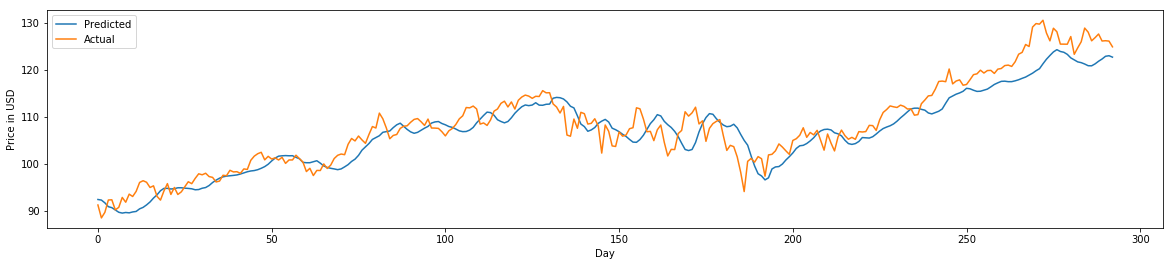

In [7]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)
fig.patch.set_facecolor('white')
ax.plot(yPred, label='Predicted')
ax.plot(actual, label='Actual')
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Price in USD')

In [8]:
# Run the simulation using test data, assume closing price for a day equals opening price for next day

balance = 0
balanceValues = []

for index, openingVal in enumerate(actual[ :-1]):
    day = index
    closingPredicted = yPred[index + 1]
    closingActual = actual[index + 1]
    
    # If prediction is larger than the opening value, then BUY
    if closingPredicted > openingVal:
        balance += closingActual - openingVal
        
    # If prediction is less than the opening value, do NOTHING
    else:
        pass
    balanceValues.append(balance)
    sleep(.1)
    print('Day:', day, 'Opening Price:', round(openingVal, 3), 'Predicted Closing Price:', round(closingPredicted, 3),
         'Actual Closing Price:', round(closingActual, 3), 'Balance', round(balance, 3))

print('Final Balance:', balance)

Day: 0 Opening Price: 91.27 Predicted Closing Price: 92.318 Actual Closing Price: 88.52 Balance -2.75
Day: 1 Opening Price: 88.52 Predicted Closing Price: 91.727 Actual Closing Price: 89.71 Balance -1.56
Day: 2 Opening Price: 89.71 Predicted Closing Price: 90.912 Actual Closing Price: 92.33 Balance 1.06
Day: 3 Opening Price: 92.33 Predicted Closing Price: 90.702 Actual Closing Price: 92.38 Balance 1.06
Day: 4 Opening Price: 92.38 Predicted Closing Price: 90.207 Actual Closing Price: 90.23 Balance 1.06
Day: 5 Opening Price: 90.23 Predicted Closing Price: 89.723 Actual Closing Price: 90.77 Balance 1.06
Day: 6 Opening Price: 90.77 Predicted Closing Price: 89.549 Actual Closing Price: 92.88 Balance 1.06
Day: 7 Opening Price: 92.88 Predicted Closing Price: 89.676 Actual Closing Price: 91.86 Balance 1.06
Day: 8 Opening Price: 91.86 Predicted Closing Price: 89.597 Actual Closing Price: 93.58 Balance 1.06
Day: 9 Opening Price: 93.58 Predicted Closing Price: 89.792 Actual Closing Price: 93.08 B

Day: 79 Opening Price: 107.97 Predicted Closing Price: 105.61 Actual Closing Price: 107.66 Balance 12.4
Day: 80 Opening Price: 107.66 Predicted Closing Price: 106.017 Actual Closing Price: 110.83 Balance 12.4
Day: 81 Opening Price: 110.83 Predicted Closing Price: 106.747 Actual Closing Price: 109.62 Balance 12.4
Day: 82 Opening Price: 109.62 Predicted Closing Price: 106.892 Actual Closing Price: 107.68 Balance 12.4
Day: 83 Opening Price: 107.68 Predicted Closing Price: 107.03 Actual Closing Price: 105.37 Balance 12.4
Day: 84 Opening Price: 105.37 Predicted Closing Price: 107.743 Actual Closing Price: 106.08 Balance 13.11
Day: 85 Opening Price: 106.08 Predicted Closing Price: 108.342 Actual Closing Price: 106.28 Balance 13.31
Day: 86 Opening Price: 106.28 Predicted Closing Price: 108.685 Actual Closing Price: 107.57 Balance 14.6
Day: 87 Opening Price: 107.57 Predicted Closing Price: 108.035 Actual Closing Price: 108.04 Balance 15.07
Day: 88 Opening Price: 108.04 Predicted Closing Price:

Day: 156 Opening Price: 111.75 Predicted Closing Price: 106.122 Actual Closing Price: 109.57 Balance 14.64
Day: 157 Opening Price: 109.57 Predicted Closing Price: 107.348 Actual Closing Price: 106.87 Balance 14.64
Day: 158 Opening Price: 106.87 Predicted Closing Price: 108.602 Actual Closing Price: 106.94 Balance 14.71
Day: 159 Opening Price: 106.94 Predicted Closing Price: 109.423 Actual Closing Price: 104.97 Balance 12.74
Day: 160 Opening Price: 104.97 Predicted Closing Price: 110.503 Actual Closing Price: 107.28 Balance 15.05
Day: 161 Opening Price: 107.28 Predicted Closing Price: 110.229 Actual Closing Price: 108.29 Balance 16.06
Day: 162 Opening Price: 108.29 Predicted Closing Price: 109.084 Actual Closing Price: 104.62 Balance 12.39
Day: 163 Opening Price: 104.62 Predicted Closing Price: 108.365 Actual Closing Price: 101.71 Balance 9.48
Day: 164 Opening Price: 101.71 Predicted Closing Price: 107.773 Actual Closing Price: 103.11 Balance 10.88
Day: 165 Opening Price: 103.11 Predict

Day: 233 Opening Price: 111.7 Predicted Closing Price: 111.722 Actual Closing Price: 111.75 Balance 16.07
Day: 234 Opening Price: 111.75 Predicted Closing Price: 111.88 Actual Closing Price: 110.39 Balance 14.71
Day: 235 Opening Price: 110.39 Predicted Closing Price: 111.886 Actual Closing Price: 110.51 Balance 14.83
Day: 236 Opening Price: 110.51 Predicted Closing Price: 111.632 Actual Closing Price: 112.83 Balance 17.15
Day: 237 Opening Price: 112.83 Predicted Closing Price: 111.457 Actual Closing Price: 113.62 Balance 17.15
Day: 238 Opening Price: 113.62 Predicted Closing Price: 110.863 Actual Closing Price: 114.5 Balance 17.15
Day: 239 Opening Price: 114.5 Predicted Closing Price: 110.66 Actual Closing Price: 114.59 Balance 17.15
Day: 240 Opening Price: 114.59 Predicted Closing Price: 110.932 Actual Closing Price: 115.91 Balance 17.15
Day: 241 Opening Price: 115.91 Predicted Closing Price: 111.227 Actual Closing Price: 117.57 Balance 17.15
Day: 242 Opening Price: 117.57 Predicted C

Text(0.5,1,'Simulation Balance')

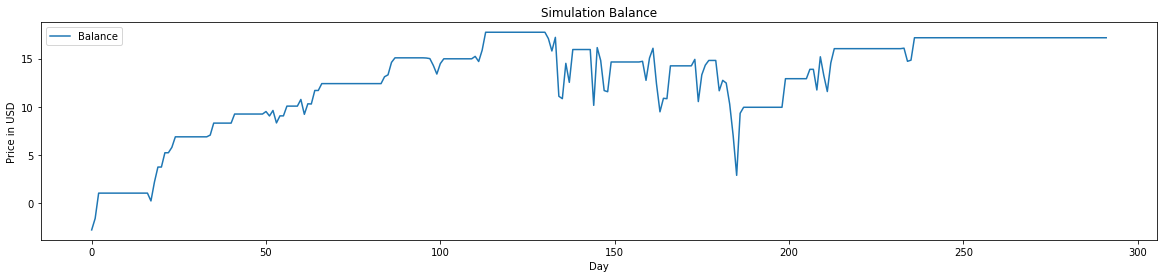

In [9]:
# Plot the overall trend of the balance

fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)
fig.patch.set_facecolor('white')
ax.plot(balanceValues, label='Balance')
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Price in USD')
ax.set_title('Simulation Balance')

Final thoughts: This model seems to predict the up/down trend pretty well, but there were a few simplifying assumptions made along the way of this analysis which probably influenced the outcome. Also its important to keep in mind that the actual vs predicted graph is expected to similar to each other since the LSTM is only predicting one value at a time, and by picking something similar to the previous 60 values, it will always fall within range of the actual value. The important prediction here is if it can reliably predict if a stock is going up or down the next day, which is what the balance graph shows.

Although deep learning seems to have some potential in modeling relatively stochastic trends, it is not likely the best way to go about investing. Regarding possible ways of improving this model, the addition of more input data could help. Using the information from similar tech stocks to predict Microsoft's trends would probably reduce loss. Additional information regarding news could also potentially included in the model through seniment analysis from different news sources, although this would require a much more sophisticated approach than the one used here.